## Аналитика в телеком компании

### Шаг 1. Изучим общую информацию

Посмотрим информацию о тарифах:

In [3]:
tariffs = tariffs.rename(columns={"tariff_name":"tariff"}) # замена, чтобы далее выполнить merge по ключу tariff
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Посмотрим информацию о пользователях:

In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В данных 2 признака, user_id и age, - количественные дискретные; 4 признака, city, first_name, last_name, tariff - категориальные; 2 призанка с датой.

Видим, что 38 клиентов прекратили пользоваться тарифом к моменту выгрузки данных.

In [6]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Было сделано 202607 звонков.

In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Было отправлено 123036 сообщений.

In [11]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Было зафиксировано 149396 интернет-сессии.

### Шаг 2. Подготовка данных и знакомство

#### usres

Посмотрим внимательнее на данные о клиентах.

In [13]:
list(users.columns)

['user_id',
 'age',
 'churn_date',
 'city',
 'first_name',
 'last_name',
 'reg_date',
 'tariff']

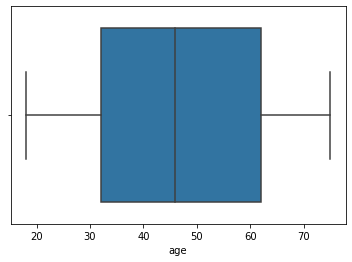

In [14]:
sns.boxplot(x='age', data=users)

In [15]:
users.age.describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

- Среднестатистическому клиенту "Мегалайн" 46 лет.

In [16]:
len(users.city.unique())

76

- Покрытие сотового оператора "Мегалайн" охватывает 76 городов России.

In [17]:
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [18]:
351/500

0.702

- 70% - клиенты тарифа "Смарт" и 30% - клиенты "Ультра".

#### calls

Посмотрим внимательнее на данные о звонках клиентов.

Так как «Мегалайн» всегда округляет вверх значения минут (то есть если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута), то округлим вверх с помощью функции np.ceil длительность звокнов и приведем к целому типу.

In [21]:
calls.duration = np.ceil(calls.duration)
calls.duration = calls.duration.astype(int)

In [22]:
len(calls.query('duration==0'))/len(calls)

0.19551644316336553

In [23]:
# считаем, что неотвеченные, сброшенные звонки расходуют 1 сек тарифного времени
calls['duration'] = calls['duration'].where(calls['duration'] != 0, 1) 

In [24]:
len(calls.query('duration==0'))/len(calls)

0.0

- Длительность 20% звонков — 0.0 минут. Скорее всего это сброшенные/неотвеченные звонки и их не нужно обрабатывать, так как они не используют тарифное время.

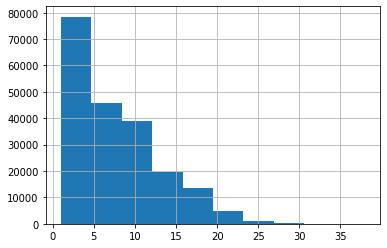

In [25]:
calls.query('duration > 0').duration.hist()

Датасет скошен вправо, есть хвост больших занчений.

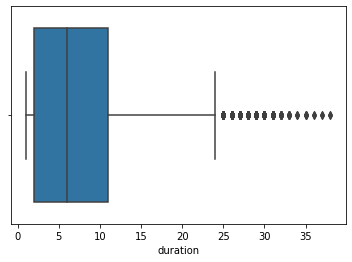

In [26]:
sns.boxplot(x='duration', data=calls)

In [27]:
calls.duration.describe()

count    202607.000000
mean          7.353714
std           5.733230
min           1.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

- Среднее время звонка 6-7 минут.

- 75% всех звонков длится до 11 минут.

- в данных есть очень длинные звонки длительностью от 25 до 40 минут.

In [28]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,1,1000
1,1000_1,2018-08-17,1,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


#### internet

Посмотрим внимательнее на данные об использовании интернета.

Так как «Мегалайн» всегда округляет вверх значения мегабайтов, округлим mb_used вверх с помощью функции np.ceil и привидем к целому типу.

In [29]:
internet.mb_used = np.ceil(internet.mb_used)
internet.mb_used = internet.mb_used.astype(int)

In [30]:
internet.mb_used.describe()

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

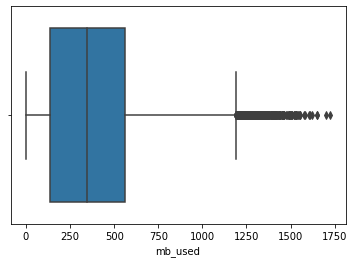

In [31]:
sns.boxplot(x='mb_used', data=internet)

In [32]:
len(internet.query('mb_used == 0'))/len(internet)

0.13118155773916304

- 13% клиентов не пользуются интеренетом.
- 75% всех клиентов используют до 600 Мб за сессию.
- есть клиенты, которые используют более 1250 Мб за сессию.

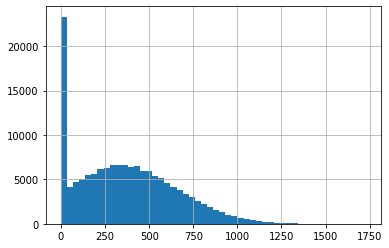

In [33]:
internet.mb_used.hist(bins=50)

Преобразуем в дату объект reg_date, call_date, message_date, session_date:

In [35]:
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d')
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m-%d')
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d')
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m-%d')

#### Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.

Добавим месяц для каждого звонка.

In [36]:
calls['month'] = calls.call_date.dt.month

Рассмотрим звонки, длительность которых больше 0 минут, так как только эти звонки расходуют минуты из тарифного плана.

In [37]:
user_calls_per_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
user_calls_per_month.columns = ['call_count', 'call_duration']

#### Посчитаем для каждого пользователя количество отправленных сообщений по месяцам.

Добавим месяц для каждого сообщения.

In [38]:
messages['month'] = messages.message_date.dt.month

In [39]:
user_messages_per_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
user_messages_per_month.columns = ['message_count']

#### Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам.

Добавим месяц для каждой интернет-сессии.

In [40]:
internet['month'] = internet.session_date.dt.month

In [41]:
user_internet_per_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

Объединим данные с помощью join outer, чтобы ничего не потерять, и заполним пропущенные значения нулями.

In [42]:
summary = user_calls_per_month.join([user_messages_per_month, user_internet_per_month], how='outer')
summary = summary.fillna(0)
summary = summary.reset_index().set_index('user_id')

Добавим с помощью merge информацию о тарифе и городе для каждого клиента.

In [43]:
summary = summary.merge(users[['user_id', 'tariff', 'city']], on='user_id')

In [44]:
summary = summary.merge(tariffs, on='tariff')

Привидем признаки - количество звонков, длительность звонков, количество смс и количество интернет-трафика - к целому типу.

In [45]:
summary.call_count = summary.call_count.astype(int)
summary.call_duration = summary.call_duration.astype(int)
summary.message_count = summary.message_count.astype(int)
summary.mb_used = summary.mb_used.astype(int)

Получим итоговую таблицу, которая для каждого клиента содержит информацию по месяцам.

In [46]:
summary

,user_id,month,call_count,call_duration,message_count,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,164,22,2256,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,43,187,60,23257,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,47,346,75,14016,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,52,418,81,14070,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,58,478,57,14581,ultra,Краснодар,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,41,258,42,20604,smart,Владикавказ,50,15360,500,550,200,3,3
3210,1499,9,9,71,11,1848,smart,Пермь,50,15360,500,550,200,3,3
3211,1499,10,68,473,48,17809,smart,Пермь,50,15360,500,550,200,3,3
3212,1499,11,74,624,59,17984,smart,Пермь,50,15360,500,550,200,3,3


#### Теперь можно узнать помесячную выручку с каждого пользователя. 

Вычислим бесплатный лимит из потраченных минут, сообщений и интернет-трафика.

In [47]:
summary['minutes_over_tariff'] = summary['call_duration'] - summary['minutes_included']
summary['minutes_over_tariff'] = summary['minutes_over_tariff'].where(summary['minutes_over_tariff'] > 0, 0) # не потрачено минут сверх тарифа
summary['messages_over_tariff'] = summary['message_count'] - summary['messages_included']
summary['messages_over_tariff'] = summary['messages_over_tariff'].where(summary['messages_over_tariff'] > 0, 0) # не потрачено смс сверх тарифа
summary['mb_over_tariff'] = summary['mb_used'] - summary['mb_per_month_included']
summary['mb_over_tariff'] = summary['mb_over_tariff'].where(summary['mb_over_tariff'] > 0, 0) # не потрачено интренет-трафика сверх тарифа

In [48]:
summary['mb_over_tariff'] = summary['mb_over_tariff'].astype(int)

In [49]:
summary['gb_used'] = (summary['mb_used']/1024).astype(int)

Остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

In [50]:
summary['cost'] = summary['rub_monthly_fee'] + \
                  summary['minutes_over_tariff']*summary['rub_per_minute'] + \
                  summary['messages_over_tariff']*summary['rub_per_message'] + \
                  summary['mb_over_tariff']/1024*summary['rub_per_gb']

In [51]:
summary['cost'] = summary['cost'].astype(int)

In [52]:
summary

,user_id,month,call_count,call_duration,message_count,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over_tariff,messages_over_tariff,mb_over_tariff,gb_used,cost
0,1000,5,22,164,22,2256,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0,0,0,2,1950
1,1000,6,43,187,60,23257,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0,0,0,22,1950
2,1000,7,47,346,75,14016,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0,0,0,13,1950
3,1000,8,52,418,81,14070,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0,0,0,13,1950
4,1000,9,58,478,57,14581,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0,0,0,14,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,41,258,42,20604,smart,Владикавказ,50,15360,500,550,200,3,3,0,0,5244,20,1574
3210,1499,9,9,71,11,1848,smart,Пермь,50,15360,500,550,200,3,3,0,0,0,1,550
3211,1499,10,68,473,48,17809,smart,Пермь,50,15360,500,550,200,3,3,0,0,2449,17,1028
3212,1499,11,74,624,59,17984,smart,Пермь,50,15360,500,550,200,3,3,124,9,2624,17,1461


In [53]:
summary['cost'].sum()

4815881

Посмотрим на помесячную выручку c пользователя с user_id = 1000:

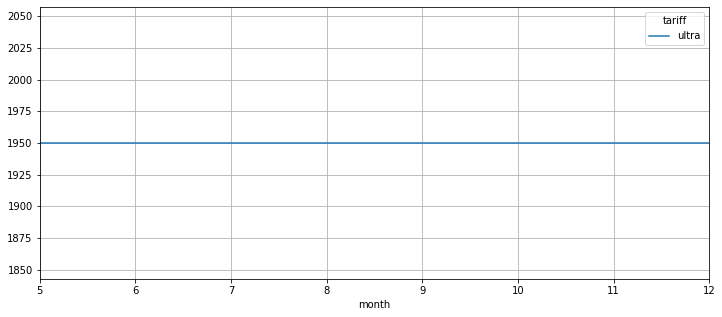

In [54]:
summary.query('user_id==1000').pivot_table(index='month', columns='tariff', values='cost').plot(grid=True, figsize=(12, 5))

Посмотрим на помесячную выручку c пользователя с user_id = 1002:

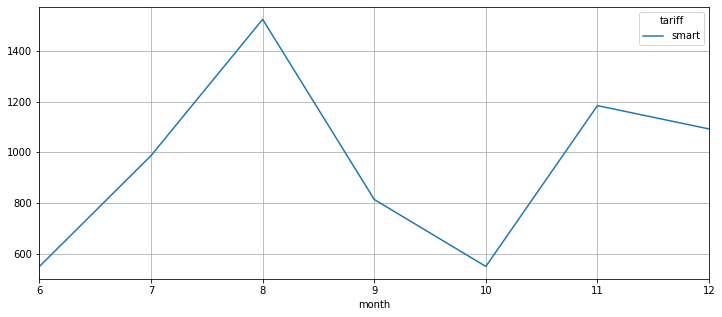

In [55]:
summary.query('user_id==1002').pivot_table(index='month', columns='tariff', values='cost').plot(grid=True, figsize=(12, 5))

Посмотрим на средднюю помесячную выручку с каждого пользователя по каждому тарифу.

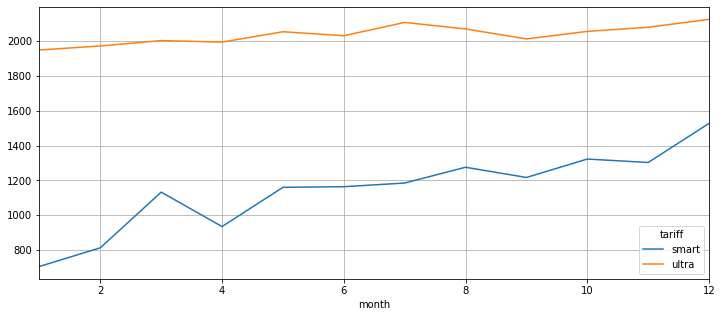

In [56]:
summary.pivot_table(index='month', columns='tariff', values='cost').plot(grid=True, figsize=(12, 5))

In [57]:
smart = summary.query('tariff == "smart"')

In [58]:
smart['cost'].sum()

2786325

In [59]:
sns.set(style="darkgrid")

#### SMART, average cost per month

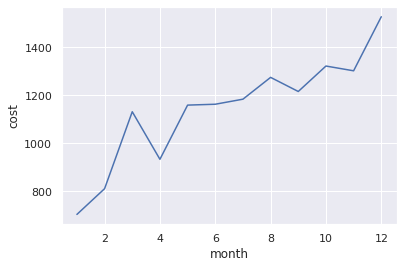

In [60]:
sns.lineplot(x='month', y='cost', data=smart.pivot_table(index='month', values='cost').reset_index())

#### ULTRA, average cost per month

In [61]:
ultra = summary.query('tariff == "ultra"')

In [62]:
ultra['cost'].sum()

2029556

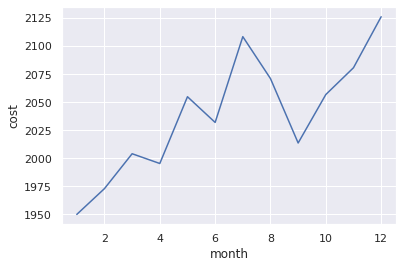

In [63]:
sns.lineplot(x='month', y='cost', data=ultra.pivot_table(index='month', values='cost').reset_index())

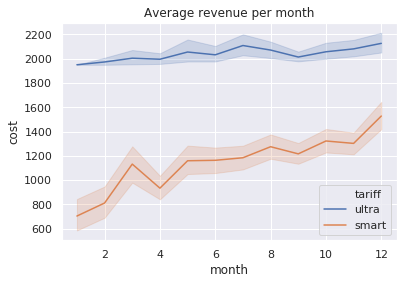

In [64]:
sns.lineplot(x="month", y="cost", hue="tariff", data=summary)
plt.title('Average revenue per month')
plt.show()

- Видим, что тариф "Ультра" приносит больше денег, чем тариф "Смарт". 

- Несмотря на то, что выручка по тарифу "Смарт" выросла за год более чем в два раза - с 700 рублей в месяц до 1600 рублей в месяц, выручка по тарифу "Ультра" такжее немного выросла и - с 1950 рублей в месяц до 2100 рублей в месяц.

### Выводы

- было выполнено первичное знакомство с даными;


- calls.duration и mb_used округлены вверх и привидены к целому ципу;


- преобразовны в дату объекты reg_date, call_date, message_date, session_date;


- для каждого пользователя было посчитано: количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам; на основе этой информации была вычислена помесячная выручка с каждого пользователя;


- для тарифов были построены графики средней выручки с каждого пользователя по месяцам: похоже, что тариф "Ультра" приносит больше денег, чем тариф "Смарт"; несмотря на то, что выручка по тарифу "Смарт" выросла с 700 рублей в месяц до 1600 рублей в месяц (более чем в два раза за год), выручка по тарифу "Ультра" тоже немного выросла и - с 1950 рублей в месяц до 2100 рублей в месяц.

### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

#### Minutes per month, SMART

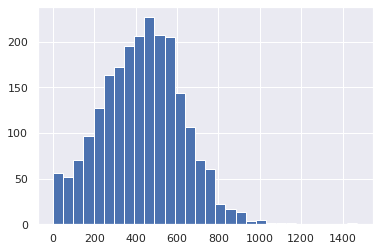

In [65]:
smart['call_duration'].hist(bins=30)

Гистограмма скошена влево, есть широкий хвост маленьких значений. Люди обычно разговаривают недолго.

In [66]:
smart['call_duration'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: call_duration, dtype: float64

In [67]:
len(smart.query('call_duration<=500'))/ len(smart)

0.636159712875729

- В среднем клиенты "Смарт" используют около 420 минут в месяц. Стандартное отклонение примерно в два раза меньше среднего.


- 66% клиентов укладывются в лимит 500 минут, включенных в тариф.


- Есть клиенты, которые примерно в два раза перерасходуют трафик по минутам, max=1435.


- Есть пользователи, которые не совершают ни одного звонка в месяц, min=0.

In [68]:
smart['call_duration'].var()

37974.774627825

#### Minutes per month, ULTRA

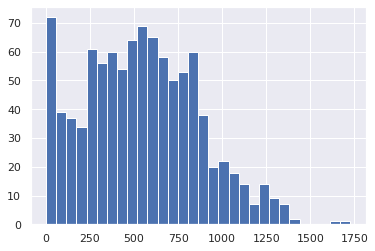

In [69]:
ultra['call_duration'].hist(bins=30)

In [70]:
ultra['call_duration'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: call_duration, dtype: float64

In [71]:
len(ultra.query('250<call_duration<900'))/ len(ultra)

0.6690355329949239

- В среднем клиенты "Ультра" используют около 520 минут в месяц. Стандартное отклонение 318.


- 67% клиентов тратят от 250 до 900 минут.


- Ни один клиент не расходует все включенные в тариф 3000 минут, max = 1673. 


- Есть пользователи, которые не совершают ни одного звонка в месяц, min=0.

In [72]:
ultra['call_duration'].var()

106105.72682307787

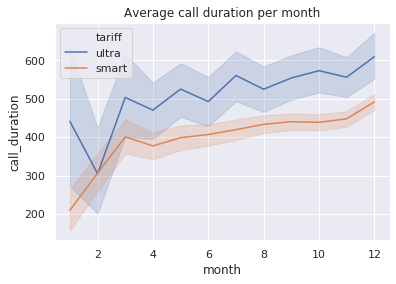

In [73]:
sns.lineplot(x="month", y="call_duration", hue="tariff", data=summary)
plt.title('Average call duration per month')
plt.show()

- Пользователям тарифа "Смарт" требовалось в среднем от 200 минут в январе до 500 минут в декабре. На протяжении года длительность раговоров росла почти каждый месяц. Таким образом клиентам хватает 500 минут включенных в тариф.


- Пользователям тарифа "Ультра" требовалось в среднем от 300 до 600 минут разговоров в месяц. На протяжении года длительность раговоров постепенно росла. Так как как в пакет входит 3000 минут, получается, что клиенты платят за то, что не используют.

#### Messages per month, SMART

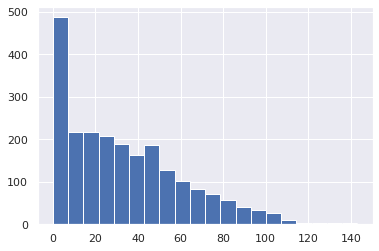

In [74]:
smart['message_count'].hist(bins=20)

Гистограмма скошена влево, есть толстый слой маленьких значений.

In [75]:
smart['message_count'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_count, dtype: float64

In [76]:
len(smart.query('message_count<=50'))/len(smart)

0.746971736204576

In [77]:
len(smart.query('message_count>50'))/len(smart)

0.253028263795424

- В среднем клиенты "Смарт" используют около 30 смс в месяц. Стандартное отклонение 28.


- 75% клиентов не выходят за лимит 50 смс, включенных в пакет.


- Есть клиенты, которые почти в два раза перерасходуют лимит смс, включенных в тариф, max=143.


- Есть пользователи, которые не отправляют ни одного смс в месяц, min=0.

In [78]:
smart['message_count'].var()

796.8129584480083

#### Messages per month, ULTRA

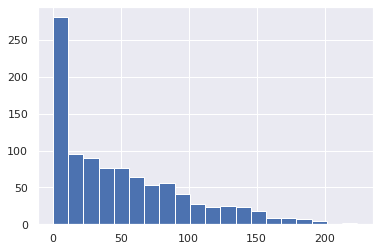

In [79]:
ultra['message_count'].hist(bins=20)

Гистограмма скошена влево, есть толстый слой маленьких значений.

In [80]:
ultra['message_count'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: message_count, dtype: float64

- В среднем клиенты "Ультра" используют около 40 смс в месяц. Стандартное отклонение 47.


- Ни один клиент не расходует все включенные в тариф 1000 смс, max = 224. 


- Есть пользователи, которые не отправляют ни одного смс в месяц, min=0.

In [81]:
ultra['message_count'].var()

2285.266142544674

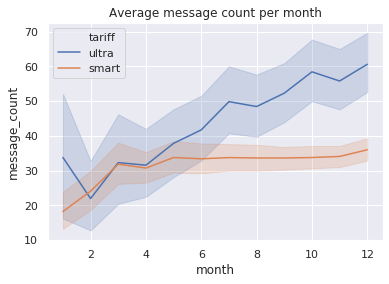

In [82]:
sns.lineplot(x="month", y="message_count", hue="tariff", data=summary)
plt.title('Average message count per month')
plt.show()

- Пользователям тарифа "Смарт" требовалось в среднем от 20 смс в январе до 40 смс в декабре. Таким образом обычно клиентам хватает 50 сообщений включенных в тариф.


- Пользователям тарифа "Ультра" требовалось в среднем от 20 до 60 смс разговоров в месяц. На протяжении года количество смс, отправленных за месяц, постепенно росла. Так как в пакет входит 1000 сообщений, получается, что клиенты платят за то, что не используют.

#### Gb per month, SMART

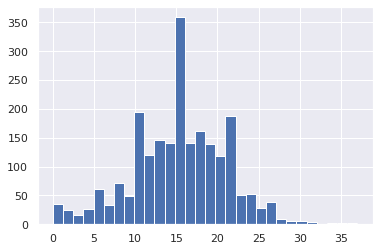

In [83]:
smart['gb_used'].hist(bins=30)

Гистограмма чуть скошена влево, медиана немного больше среднего.

In [84]:
smart['gb_used'].describe()

count    2229.000000
mean       15.360700
std         5.757206
min         0.000000
25%        12.000000
50%        16.000000
75%        19.000000
max        37.000000
Name: gb_used, dtype: float64

In [85]:
len(smart.query('gb_used>15'))/len(smart)

0.5087483176312247

- В среднем клиенты "Смарт" чуть перерасходуют трафик, используя 16 Гб в месяц. Стандартное отклонение 5.7.


- 51% клиентов перерасходуют трафки интеренета.


- Есть пользователи, которые совсем не пользуются интернетом, min=0.

In [86]:
smart['gb_used'].var()

33.145420694887775

#### Gb per month, ULTRA

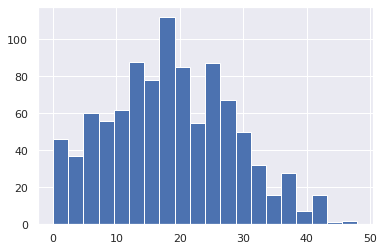

In [87]:
ultra['gb_used'].hist(bins=20)

In [88]:
ultra['gb_used'].describe()

count    985.000000
mean      18.540102
std        9.842802
min        0.000000
25%       11.000000
50%       18.000000
75%       26.000000
max       48.000000
Name: gb_used, dtype: float64

In [89]:
len(ultra.query('gb_used>30'))/ len(ultra)

0.12385786802030457

- В среднем клиенты "Ультра" используют около 20 Гб в месяц. Стандартное отклонение 10.


- 12% не хватает 30 Гб включенных в пакет, они перерасходут трафик.


- Есть пользователи, которые совсем не пользуются интернетом, min=0.

In [90]:
ultra['gb_used'].var()

96.88075811976393

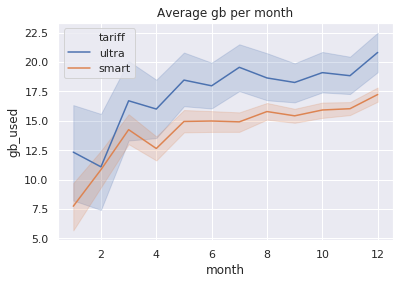

In [91]:
sns.lineplot(x="month", y="gb_used", hue="tariff", data=summary)
plt.title('Average gb per month')
plt.show()

- Пользователям тарифа "Смарт" требовалось в среднем от 7.5 Гб в январе до 17.5 Гб в декабре. С июля клиенты начинают немного перерасходуовать трафик, им не хватает 15 Гб, влюченных в тариф.


- Пользователям тарифа "Ультра" требовалось в среднем от 11 до 22 Гб в месяц. На протяжении года количество Гб, использованных за месяц, постепенно росла.

### Выводы

Анализ поведения клиентов оператора, исходя из выборки, показал:

1) клиенты тарифа "Смарт" в среднем используют: 

- около 420 минут в месяц; 66% укладывются в лимит 500 минут, включенных в тариф, остальные перерасходут трафик; 

- около 30 смс в месяц; 75% клиентов не выходят за лимит 50 смс, включенных в пакет, остальные перерасходут трафик; 

- около 16 Гб в месяц, 51% клиентов перерасходуют трафик интеренета;


2) клиенты тарифа "Ультра" в среднем используют: 

- около 520 минут в месяц; ни один клиент не расходует все включенные в тариф 3000 минут;

- около 40 смс в месяц; ни один клиент не расходует все включенные в тариф 1000 смс;

- около 20 Гб в месяц, 12% не хватает 30 Гб включенных в пакет, они перерасходут трафик.

### Шаг 4. Проверьте гипотезы

1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. 

Нулевая гипотеза является предположением, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается. Определим уровень значимости 1%. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind() с параметром equal_var = False, так как нет основания полагать, что выборки взяты из схожих по парамтерам совокупностей.

In [92]:
alpha = 0.01

results = st.ttest_ind(smart['cost'], ultra['cost'], equal_var=False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Скорее всего средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.')
else:
    print('Не можем отвергнуть нулевую гипотезу, возможно, средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.')

p-значение:  1.8049203687159555e-282
Отвергаем нулевую гипотезу. Скорее всего средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.


2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза является предположением, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Определим уровень значимости 5%. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind().

In [93]:
summary_moscow = summary.query('city=="Москва"')
summary_not_moscow = summary.query('city!="Москва"')

In [94]:
alpha = 0.05

results = st.ttest_ind(summary_moscow['cost'], summary_not_moscow['cost'])
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Скорее всего средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.')
else:
    print('Не можем отвергнуть нулевую гипотезу. Возможно средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.')

p-значение:  0.5201991925651426
Не можем отвергнуть нулевую гипотезу. Возможно средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.


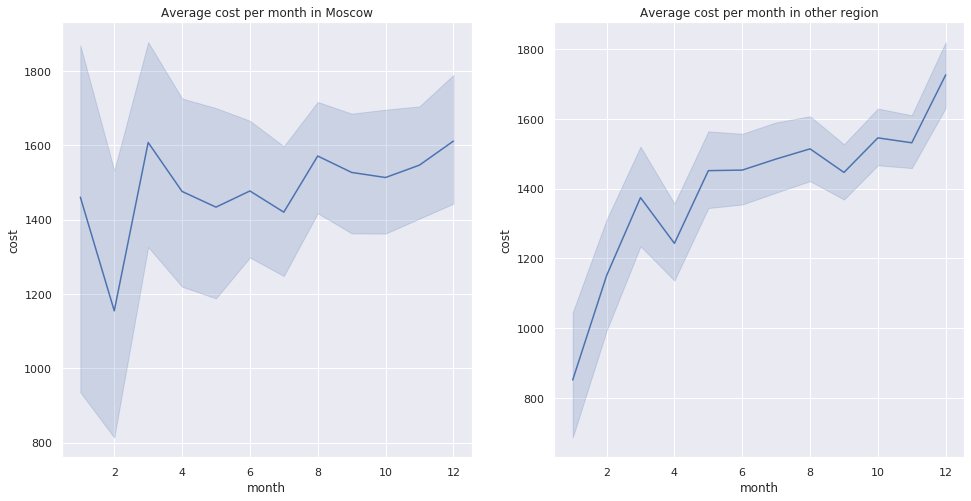

In [95]:
plt.figure(figsize=(25,8))
plt.subplot(1, 3, 1)
sns.lineplot(x="month", y="cost", data=summary_moscow)
plt.title('Average cost per month in Moscow')
plt.subplot(1, 3, 2)
sns.lineplot(x="month", y="cost", data=summary_not_moscow)
plt.title('Average cost per month in other region')
plt.show()

В среднем выручка с каждого пользователя в Москве была от 1200 рублей до 1600 рублей, что является подмножеством выручки для других регионов - от 900 рублей до 1700 рублей в месяц.

### Выводы

1) Отвергли нулевую гипотезу с уровенем значимости 1%: скорее всего средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

2) Не смогли отвергнуть нулевую гипотезу с уровнем значимости 5%: возможно средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

### Общий вывод

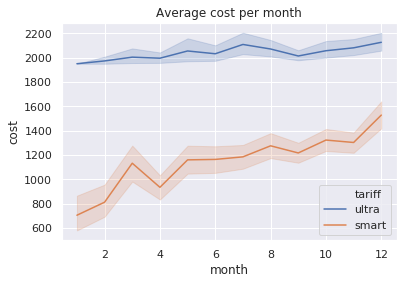

In [96]:
sns.lineplot(x="month", y="cost", hue="tariff", data=summary)
plt.title('Average cost per month')
plt.show()

- Видим, что **тариф "Ультра" приносит больше денег, чем тариф "Смарт"**. 


- Несмотря на то, что абонентская плата по тарифу "Смарт" выросла за год более чем в два раза - с 700 рублей в месяц до 1600 рублей в месяц, выручка по тарифу "Ультра" такжее немного выросла и - с 1950 рублей в месяц до 2100 рублей в месяц.


Анализ поведения клиентов оператора показал:

1) клиенты тарифа "Смарт" в среднем используют: 

- около 420 минут в месяц; 66% укладывются в лимит 500 минут, включенных в тариф, остальные перерасходут трафик; 

- около 30 смс в месяц; 75% клиентов не выходят за лимит 50 смс, включенных в пакет, остальные перерасходут трафик; 

- около 16 Гб в месяц, 51% клиентов перерасходуют трафик интеренета;


2) клиенты тарифа "Ультра" в среднем используют: 

- около 520 минут в месяц; ни один клиент не расходует все включенные в тариф 3000 минут;

- около 40 смс в месяц; ни один клиент не расходует все включенные в тариф 1000 смс;

- около 20 Гб в месяц, 12% не хватает 30 Гб включенных в пакет, они перерасходут трафик.


Видим, что на самом деле потребности пользователей двух тарифов не сильнот отличаются друг от друга. Поэтому можно сделать вывод, что 
бОльшая выручка от тарифа "Ультра" свзяна с большей абонентской платой, при этом пользователа не расходуют весь лимит звонков и смс, однако им почти хватает 30 Гб интренета.

Возможно, *оптимальным для пользователей* был бы тариф, содержащий: 1500 минут, 150 смс и 30 Гб.